In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = 2,
    c2 = 2,
    w = 1,
    w_decay = 1,
    scale_hyperparameter = False,
    regularizer = l2_regularizer,
    mask = True))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 2
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

Checkpoint 100, Accuracy: 0.9506172839506173, Loss: 0.34022931699399594
Checkpoint 200, Accuracy: 0.9382716049382716, Loss: 0.3328574851707176
Checkpoint 300, Accuracy: 0.9382716049382716, Loss: 0.33013682895236546
Checkpoint 400, Accuracy: 0.9444444444444444, Loss: 0.3285620300858109
Checkpoint 500, Accuracy: 0.9444444444444444, Loss: 0.3353748674745913


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[0. 0. 1.] <-> [0.2927256  0.00797304 0.69930136]
[1. 0. 0.] <-> [0.8044202  0.07873374 0.11684602]
[1. 0. 0.] <-> [0.8129859  0.10675819 0.08025593]
[1. 0. 0.] <-> [0.75687337 0.05077088 0.19235568]
[0. 0. 1.] <-> [0.7136584  0.02747332 0.25886822]
[1. 0. 0.] <-> [0.76435906 0.05781346 0.1778275 ]
[0. 1. 0.] <-> [0.5804648  0.38125318 0.03828206]
[1. 0. 0.] <-> [0.815978   0.08438507 0.09963698]
[1. 0. 0.] <-> [0.775707   0.04011592 0.18417713]
[1. 0. 0.] <-> [0.6004635  0.03063371 0.36890274]
[1. 0. 0.] <-> [0.80813634 0.11930183 0.0725618 ]
[1. 0. 0.] <-> [0.82555807 0.04346418 0.13097768]
[0. 0. 1.] <-> [0.3086449  0.00852638 0.6828287 ]
[1. 0. 0.] <-> [0.79945153 0.07334705 0.12720148]
[1. 0. 0.] <-> [0.7563347  0.03456505 0.20910016]
[1. 0. 0.] <-> [0.79857224 0.0722973  0.12913038]
[1. 0. 0.] <-> [0.82921374 0.0840597  0.08672664]
[1. 0. 0.] <-> [0.77899766 0.15802705 0.06297527]
[1. 0. 0.] <-> [0.8337341  0.08087531 0.08539063]
[1. 0. 0.] <-> [0.7999284  0.11500394 0.08506756]


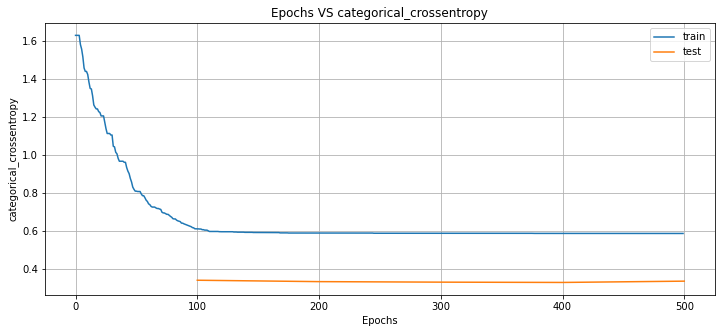

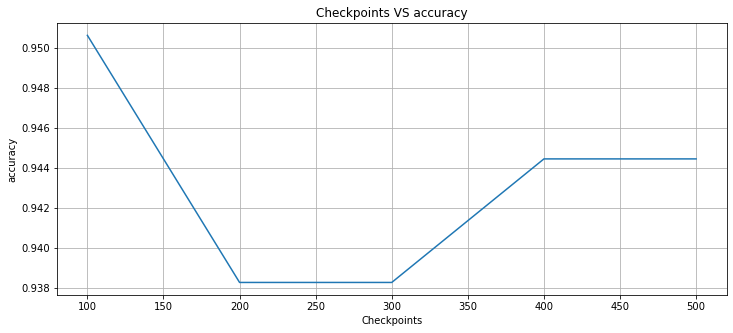

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [12]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9506172839506173, 'mean_square_error': 0.16270850117168636, 'categorical_crossentropy': 0.34022931699399594, 'essential_metrics': {0: {'tp_hit': 80, 'fp_hit': 8, 'tn_hit': 20, 'fn_hit': 0}, 1: {'tp_hit': 10, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 5}, 2: {'tp_hit': 10, 'fp_hit': 0, 'tn_hit': 95, 'fn_hit': 3}}, 'checkpoint': 100} 


{'accuracy': 0.9382716049382716, 'mean_square_error': 0.15924070067643004, 'categorical_crossentropy': 0.3328574851707176, 'essential_metrics': {0: {'tp_hit': 80, 'fp_hit': 10, 'tn_hit': 18, 'fn_hit': 0}, 1: {'tp_hit': 8, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 7}, 2: {'tp_hit': 10, 'fp_hit': 0, 'tn_hit': 95, 'fn_hit': 3}}, 'checkpoint': 200} 


{'accuracy': 0.9382716049382716, 'mean_square_error': 0.15966827517936122, 'categorical_crossentropy': 0.33013682895236546, 'essential_metrics': {0: {'tp_hit': 80, 'fp_hit': 10, 'tn_hit': 18, 'fn_hit': 0}, 1: {'tp_hit': 8, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 7}, 2: {'tp_hit': 10, 'fp_hit': 0, 'tn_hit': 95, 

In [13]:
print(model)

Layer 1
Neuron 0: weights:
[ 0.5104621  -1.1608641  -0.7176463  -0.29335657  0.130649  ]
 bias: 0.5755797624588013

Neuron 1: weights:
[ 0.2438047  -0.68806857 -0.2067758   0.33354306  0.69946367]
 bias: -0.31307217478752136

Neuron 2: weights:
[-0.39868304  0.68912363  0.378559   -0.86995244 -0.8534291 ]
 bias: 0.9000799655914307

Neuron 3: weights:
[-0.33365658  1.0174592   0.66852134 -0.03348993 -0.38214418]
 bias: -0.46672046184539795

$
Layer 2
Neuron 0: weights:
[ 1.1374654  -0.26610446  1.0104704  -0.52310866]
 bias: 0.10581278055906296

Neuron 1: weights:
[-1.7465733 -1.0651913  0.5677425  1.3517709]
 bias: 0.01579415798187256

Neuron 2: weights:
[ 0.4414268  1.4666737 -1.7009864 -0.8492253]
 bias: -0.08517371118068695

$

